In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


#  House pricing analysis 

Cieľ: na základe dát ako ulica na ktorej sa byt nachádza, vybavenie bytu, susedstvo, atď. **odhadnite cenu bytu**.

Dátový súbor obsahuje 2919 záznamom a 81 premenných (po spojení tréningového a testovacieho súboru, z dôvodu rovnakej úpravy dát. Pred predikciou bol opäť rozdelený).

Zvolený postup: 
1. zoznámenie sa s dátami (predchádzajúci notebook)
2. vysporiadanie sa s chýbajúcimi pozorovaniami:
- odstránenie niektorých záznamov (ak chábalo jediné porozovanie z celého datasetu)
- nahradenie "missing values" (numerical) pomocou mediánu
- ponechanie "missing values" z dôvodu, že by aj oni mohli priniesť informáciu pre odhad ceny
3. "One hot encoding" kategorických premenných 
4. Zvolenie správnej Neurónovej siete pre odhad ceny
5. Finálny odhad

In [6]:
from google.colab import files
uploaded = files.upload()

Saving HousePricesAll.csv to HousePricesAll.csv


In [21]:
df1 = pd.read_csv("HousePricesAll.csv")

In [22]:
df1.shape

(2919, 81)

#Numerické premenné

Zistenie počtu chábajúcich pozorovaní pre numerické premenné. 
- Ak sa v celom stĺpci nachádzal len jeden chábajúci záznam, tak sme vymazal len daný riadok. Takto som prišiel o 3 záznamy.
- V prípade premennej **MaSVnArea** som tiež odstránil 23 zázánamov.
- Premenné **LotFrontageArea, GarageYrBlt** - som chábajúce pozorovania nahradil mediánom z daného stĺpcu


In [23]:
integerDrop = []

for i in range(df1.shape[1]):
    if (df1.dtypes[i] == 'int64' or df1.dtypes[i] == 'float64') and df1.isna().sum()[i]:
        
        print("In Column %s is %d missing values" %(df1.columns[i],df1.isna().sum()[i]))
        
        if df1.isna().sum()[i] < 24:
            integerDrop.append(df1.columns[i])

In Column LotFrontage is 486 missing values
In Column MasVnrArea is 23 missing values
In Column BsmtFinSF1 is 1 missing values
In Column BsmtFinSF2 is 1 missing values
In Column BsmtUnfSF is 1 missing values
In Column TotalBsmtSF is 1 missing values
In Column BsmtFullBath is 2 missing values
In Column BsmtHalfBath is 2 missing values
In Column GarageYrBlt is 159 missing values
In Column GarageCars is 1 missing values
In Column GarageArea is 1 missing values


In [24]:
df1 = df1.dropna(axis = 0,subset = integerDrop)
df1.shape


(2893, 81)

Premenné ktoré neobsahovali viac ako 90% záznamov (niektoré až 99%) sme odstránili úplne.

In [25]:
df1.drop(["PoolQC","Fence","MiscFeature","Alley","FireplaceQu"], axis = 1, inplace = True)


In [26]:
medians = df1.loc[:,['LotFrontage','GarageYrBlt']].median()

df1['LotFrontage'] = df1['LotFrontage'].replace(np.nan,medians[0])
df1['GarageYrBlt'] = df1['GarageYrBlt'].replace(np.nan,medians[1])

df1 = df1.replace(np.nan,'None')

Nasledujúce dve premenné spůsobobali problém pri normalizácií (tvorili Nan hodnoty v stĺpčeku) a preto dané riadky s chýbajúcimi pozorovaniami odstránim už teraz. Predpokladám že je to kvôli tomu, že pri std python zaokrúhli drobné číslo na 0 (tým pádom delenie 0).


In [27]:
df1 = df1.dropna(axis = 0,subset = ['SaleType','MSZoning'])
df1.shape

(2893, 76)

#Kategoriálne premenné

Opäť sme najprv zistili počet chýbajúcich pozorovaní a vysporiadali sa s danou situáciou podobne ako pri numerických pr.

In [28]:
categoricalDrop = []

for i in range(df1.shape[1]):
    if (df1.dtypes[i] == 'object' ) and df1.isna().sum()[i]:
        
        print("In Column %s is %d missing values" %(df1.columns[i],df1.isna().sum()[i]))
        
        if df1.isna().sum()[i] < 10:
            categoricalDrop.append(df1.columns[i])
        
        

In [29]:
df1 = df1.dropna(axis = 0,subset = categoricalDrop)
df1.shape

(2893, 76)

Skontrolovanie počtu katogórií kategorických premenných. a uvažovnie nad možnosťou spojiť tie, ktoré obsahujú malý počet pozorovaní do kategórie others. To sme spravili iba v prípade premenných **Condition2,RoofMatl**

In [30]:
categoricalColumns = []
for name in df1.columns:
    
    if df1.dtypes[name] == "object":
        categoricalColumns.append(name)
        print( "The column %s has: %d categories" %(name,len(df1[name].unique())))

The column MSZoning has: 6 categories
The column Street has: 2 categories
The column LotShape has: 4 categories
The column LandContour has: 4 categories
The column Utilities has: 3 categories
The column LotConfig has: 5 categories
The column LandSlope has: 3 categories
The column Neighborhood has: 25 categories
The column Condition1 has: 9 categories
The column Condition2 has: 8 categories
The column BldgType has: 5 categories
The column HouseStyle has: 8 categories
The column RoofStyle has: 6 categories
The column RoofMatl has: 8 categories
The column Exterior1st has: 16 categories
The column Exterior2nd has: 17 categories
The column MasVnrType has: 4 categories
The column ExterQual has: 4 categories
The column ExterCond has: 5 categories
The column Foundation has: 6 categories
The column BsmtQual has: 5 categories
The column BsmtCond has: 5 categories
The column BsmtExposure has: 5 categories
The column BsmtFinType1 has: 7 categories
The column BsmtFinType2 has: 7 categories
The colu

Nasledujúce premenné podobne ako pri numerických pr. tvorili Nan hodnoty po normalizácií. Každé sme upravili odlišným spôsobom:
1. **Utilities** - premenná ktorá obsahovla 2 kategórie (unikátne hodnoty). Avšak jedna z kat. obsahovala iba jednu hodnotu. To znamená, že každý dom mal rovanú hodnotu Utilities a preto na tejto premennej vlastne záležať nemôže.
2.**Condition2, RoofMatl** - premenné, kde posledné 4 kategórie vždy obsahovali po jednej alebo dvoch hodnotách, preto sme vytvorili špeciálnu kategóriu a to kat. **Others**.

In [31]:
df1.drop(['Utilities'], axis = 1, inplace = True)

df1['Condition2'] = df1['Condition2'].replace(['RRNn ','RRAe','RRAn'],'Others')

df1['RoofMatl'] = df1['RoofMatl'].replace(['Roll', 'ClyTile','Membran','Metal'],'Others')


df1.shape

(2893, 75)

.

"One hot encoding" kategorických premenných pre potreby NN.

In [32]:
df1 = pd.get_dummies(df1, columns=categoricalColumns.remove('Utilities'))

In [33]:
#split na tie co budem odhadovat a testovacie a treningove 

dfTestTrain = df1.loc[df1['SalePrice'] != 0 ]
dfPrediction = df1.loc[df1['SalePrice'] == 0 ]

labels = dfTestTrain['SalePrice'].array
dfTestTrain = dfTestTrain.drop(['SalePrice'], axis = 1)

In [34]:
labels = np.array(labels)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(dfTestTrain, labels, train_size = 0.8, random_state = 20)


print("Train shape is: (%d,%d)" %(X_train.shape[0],X_train.shape[1]))
print("Test shape is: (%d,%d)" %(X_test.shape[0],X_test.shape[1]))
print("Train target shape is: (%d,)" %(y_train.shape[0]))
print("Train target shape is: (%d,)" %(y_test.shape[0]))

Train shape is: (1161,281)
Test shape is: (291,281)
Train target shape is: (1161,)
Train target shape is: (291,)


#Škálovanie 

Po bližšom nahliadnutí na rôznorodosť variability dát (min, max, mean), som sa rozhodol pre škálovanie dát. Typicky sa používajú dve možnosti normmalizácie dát:

1. pomocou **MinMaxScaler** - (x - x_min) / (x_max - x_min). Pomocou nej sa mi podarilo dostať lepšie výsledky.

2. pomocou **Normalizer** - (x - mean)/std. 

In [36]:
X_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_None,...,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.0,...,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.0,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000
mean,730.233419,57.734711,69.619294,10507.368648,6.091301,5.587425,1970.985357,1985.050818,104.810508,439.101637,46.011197,569.485788,1054.598622,1160.687339,343.037037,5.671835,1509.396210,0.415159,0.057709,1.559862,0.369509,2.853575,1.046512,6.505599,0.611542,1978.631352,1.760551,471.048234,97.695952,47.568475,20.818260,3.038760,15.845823,2.911283,28.978467,6.282515,2007.834625,0.007752,0.043066,0.0,...,0.012920,0.054264,0.006891,0.267873,0.055986,0.232558,0.055986,0.286822,0.424634,0.002584,0.034453,0.011197,0.055986,0.001723,0.894057,0.001723,0.025840,0.007752,0.055986,0.004307,0.904393,0.057709,0.018088,0.924203,0.027562,0.003445,0.000861,0.006891,0.003445,0.001723,0.079242,0.0,0.002584,0.874246,0.072351,0.003445,0.009475,0.009475,0.823428,0.081826
std,422.298740,42.973953,22.688933,10732.347731,1.388475,1.136911,30.321592,20.711150,182.101218,456.458050,159.390820,442.558997,445.083058,391.179943,434.633277,47.898797,528.466555,0.520190,0.240570,0.554052,0.500414,0.814263,0.222618,1.613578,0.644476,23.855026,0.747082,213.957725,128.329545,68.553734,60.258585,27.206763,57.366783,40.858354,203.163058,2.697913,1.322956,0.087741,0.203094,0.0,...,0.112978,0.226635,0.082759,0.443042,0.229994,0.422645,0.229994,0.452472,0.494500,0.050789,0.182468,0.105268,0.229994,0.041487,0.307897,0.041487,0.158726,0.087741,0.229994,0.065512,0.294179,0.233293,0.133327,0.264787,0.163786,0.058621,0.029348,0.082759,0.058621,0.041487,0.270233,0.0,0.050789,0.331714,0.259181,0.058621,0.096917,0.096917,0.381470,0.274218
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.000000,0.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Výber architektúry neurónovej siete

Nakoniec som zvolil architektúru typu **281-64-64-32-1** aj z dôvodu aby nebola príliš robustná a NN sa rýchlo nepreučila. 
- Stálo by zváženie skúsenie rôznych druhov aktivačných funkcii ako **selu, tanh...** avšak k najlepšej MAE (priemernej absolútnej chybe) som sa dostal pomocou nasledovnej NN.

In [38]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization
from keras import optimizers

#adam = optimizers.SGD(lr=0.1, decay=0.1, momentum=0.90, nesterov=True)

model = Sequential()
model.add(Dense(64, activation='relu',input_shape=(X_train.shape[1],))),
model.add(Dense(64, activation='relu')),
model.add(Dense(32, activation='relu')),
model.add(Dense(1)),
model.compile(optimizer='rmsprop', loss='mae') 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                18048     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 24,321
Trainable params: 24,321
Non-trainable params: 0
_________________________________________________________________


.


Najnižšie s MAE som sa dostal k hodnote **14899** , tj. priemerný rozdiel medzi reálnou a odhadnoutou cenou testovacieho súboru bolo približne 15000 dolárov. To je stále vysoký rozdiel a určite by sa táto hodnota dala ešte znížiť použitím odlišnej NN.

In [39]:
models_data = model.fit(X_train, y_train, epochs=120,batch_size=1, verbose=2,validation_data=(X_test,y_test))

Epoch 1/120
1161/1161 - 1s - loss: 93519.6641 - val_loss: 42584.9766
Epoch 2/120
1161/1161 - 1s - loss: 36958.3438 - val_loss: 35660.4883
Epoch 3/120
1161/1161 - 1s - loss: 31550.0645 - val_loss: 33249.4141
Epoch 4/120
1161/1161 - 1s - loss: 28920.2617 - val_loss: 29615.1855
Epoch 5/120
1161/1161 - 1s - loss: 26870.0449 - val_loss: 28291.4336
Epoch 6/120
1161/1161 - 1s - loss: 25010.8105 - val_loss: 25491.2871
Epoch 7/120
1161/1161 - 1s - loss: 23257.3203 - val_loss: 23467.8438
Epoch 8/120
1161/1161 - 1s - loss: 21695.2910 - val_loss: 21723.3184
Epoch 9/120
1161/1161 - 1s - loss: 20466.8379 - val_loss: 20864.9629
Epoch 10/120
1161/1161 - 1s - loss: 19604.7695 - val_loss: 19567.2539
Epoch 11/120
1161/1161 - 1s - loss: 18912.3496 - val_loss: 18939.1582
Epoch 12/120
1161/1161 - 1s - loss: 18363.1895 - val_loss: 19248.9355
Epoch 13/120
1161/1161 - 1s - loss: 17843.4297 - val_loss: 18596.4902
Epoch 14/120
1161/1161 - 1s - loss: 17569.7832 - val_loss: 17624.9531
Epoch 15/120
1161/1161 - 1s -

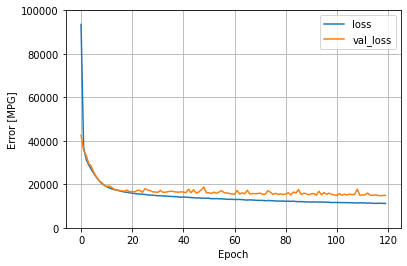

In [40]:
def plot_loss(model):
  plt.plot(model.history['loss'], label='loss')
  plt.plot(model.history['val_loss'], label='val_loss')
  plt.ylim([0, 100000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(models_data)


In [43]:
model.save(r'my_model.h5')

In [44]:
model = load_model(r"saved_model/my_model.h5")

In [45]:
dfPrediction = dfPrediction.drop(['SalePrice'], axis = 1)
dfPrediction.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_None,...,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1461,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1462,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1463,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1464,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [46]:
dfPrediction1 = scaler.transform(dfPrediction)


In [47]:
SalePrice = []

for i in range(dfPrediction.shape[0]):
    
    x = np.expand_dims(dfPrediction1[i,:], axis=0)
    
    SalePrice.append(model.predict(x)[0][0])
    
dfPrediction['SalePrice'] = SalePrice    



**Finálny súbor s predikovanými hodntami zo súboru test.csv**

In [48]:
dfPrediction

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_None,...,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
1460,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,127791.703125
1461,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,94061.625000
1462,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,189129.312500
1463,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,200927.390625
1464,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,187352.828125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,1979.0,0.0,0.0,0,0,0,0,0,0,0,6,2006,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,88673.007812
2915,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1970.0,1.0,286.0,0,24,0,0,0,0,0,4,2006,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,80993.757812
2916,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,1960.0,2.0,576.0,474,0,0,0,0,0,0,9,2006,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,168251.437500
2917,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,1979.0,0.0,0.0,80,32,0,0,0,0,700,7,2006,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,116406.125000
